# <font color="purple"> Movie Rating Prediction Project </font>

## <font color="purple"> Introduction </font>

<font color="purple"> **Project Goal:**</font>

The goal of this project is to build a machine learning model that can accurately predict audience ratings for movies based on various features. This model can help in understanding what factors influence audience preferences, assisting with movie production decisions, and potentially enabling personalized recommendations.

<font color="purple">**Data:**</font>

The dataset includes information about movies, including release dates, plot summaries, critical reviews, cast and crew, genre, and ratings.


## <font color="purple">  1. Setup and Data Loading </font>

###  <font color="purple"> 1.1. Import Libraries </font>

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import nltk
import xgboost as xgb  

In [233]:
import warnings
warnings.filterwarnings('ignore')

### <font color="purple"> 1.2. Define Constants </font>

In [165]:
RANDOM_STATE = 42  # For reproducibility
N_TOPICS = 5      # Number of topics for text analysis
TEXT_COLS = ['movie_info', 'critics_consensus', 'writers', 'cast', 'genre'] # Text columns
NUMERIC_COLS = ['tomatometer_rating', 'tomatometer_count', 'runtime_in_minutes'] # Numerical columns
CATEGORICAL_COLS = ['rating', 'studio_name', 'tomatometer_status', 'directors'] # Categorical columns
DATE_COLS = ['in_theaters_date', 'on_streaming_date'] # Date columns
DROP_COLS = []    # Columns to drop before modeling
CARDINALITY_THRESHOLD = 20 # Max number of categories before feature removal
TOP_N_FEATURES = 10 # Top features to select

### <font color="purple"> 1.3. Load Data </font>

In [166]:
df = pd.read_excel("rotten_tomatoes_movies.xls") 

## <font color="purple"> 2. Exploratory Data Analysis (EDA) </font>


<font color="purple"> **Objective:** </font>

In this section, we explore the dataset to understand its characteristics, identify patterns, and uncover potential issues, such as missing values and outliers. The insights gained here inform our feature engineering strategy.


### <font color="purple"> 2.1. Inspect Data Structure <font color="purple">

In [167]:
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

### <font color="purple">2.2. Descriptive Statistics<font color="purple">

In [169]:
df.describe(include='all')

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
count,16638,16614,8309,16638,16621,16524,15289,16354,15823,16636,16483.000000,16222,16638,16638.000000,16638.000000,16386.000000
unique,16106,16613,8307,8,1080,8314,12121,16326,NaN,NaN,NaN,2886,3,NaN,NaN,NaN
top,Home,An adaptation of the Broadway drama about Prin...,"Extinction has a few intriguing ideas, but the...",R,Drama,Alfred Hitchcock,Woody Allen,Chris Rock,NaN,NaN,NaN,Paramount Pictures,Rotten,NaN,NaN,NaN
freq,5,2,2,6136,1727,36,33,4,NaN,NaN,NaN,497,7233,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-10-24 22:10:52.973519488,2008-08-13 13:35:49.266650624,102.391494,NaN,NaN,60.466522,56.607104,60.470829
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1914-06-01 00:00:00,1935-06-06 00:00:00,1.000000,NaN,NaN,0.000000,5.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993-03-29 00:00:00,2003-01-28 00:00:00,90.000000,NaN,NaN,38.000000,12.000000,45.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-08-04 00:00:00,2008-04-08 00:00:00,99.000000,NaN,NaN,66.000000,28.000000,62.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-28 00:00:00,2014-05-12 00:00:00,111.000000,NaN,NaN,86.000000,76.000000,77.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:00:00,2019-11-01 00:00:00,2000.000000,NaN,NaN,100.000000,497.000000,100.000000


### <font color="purple"> 2.2.1. Drop High Cardinality data <font color="purple">

Dropping fields with names with high cardinality, as movie_title,movie_info and critics_consensus can be used to extract topics

In [170]:
df = df.drop(['directors','writers','cast'],axis=1)

In [171]:
CATEGORICAL_COLS.remove('directors')
TEXT_COLS.remove('writers')
TEXT_COLS.remove('cast')

### <font color="purple">2.3. Missing Value Analysis</font>


<font color="purple">**Handling Missing Values:**</font>
Before modeling, need to address any missing values in the dataset.


In [172]:
df.isnull().sum()

movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64

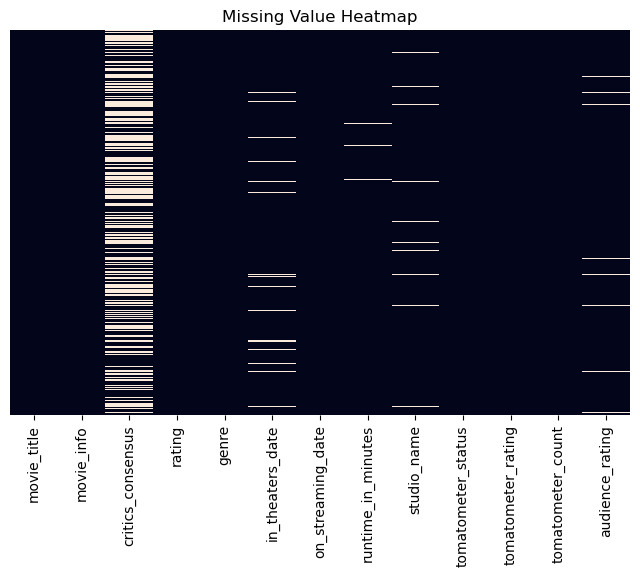

In [173]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False) 
plt.title("Missing Value Heatmap")
plt.show()

Dropping Null rows from Date fields as that cannot will be difficult to impute during feature engineering

In [174]:
df = df.dropna(subset=['in_theaters_date', 'on_streaming_date'])

###  <font color="purple">2.4. Distribution of Numerical Features:</font>

<font color="purple">**Analyzing Numerical Features:**</font>
Analyze the distribution of numerical features to understand their data characteristics.


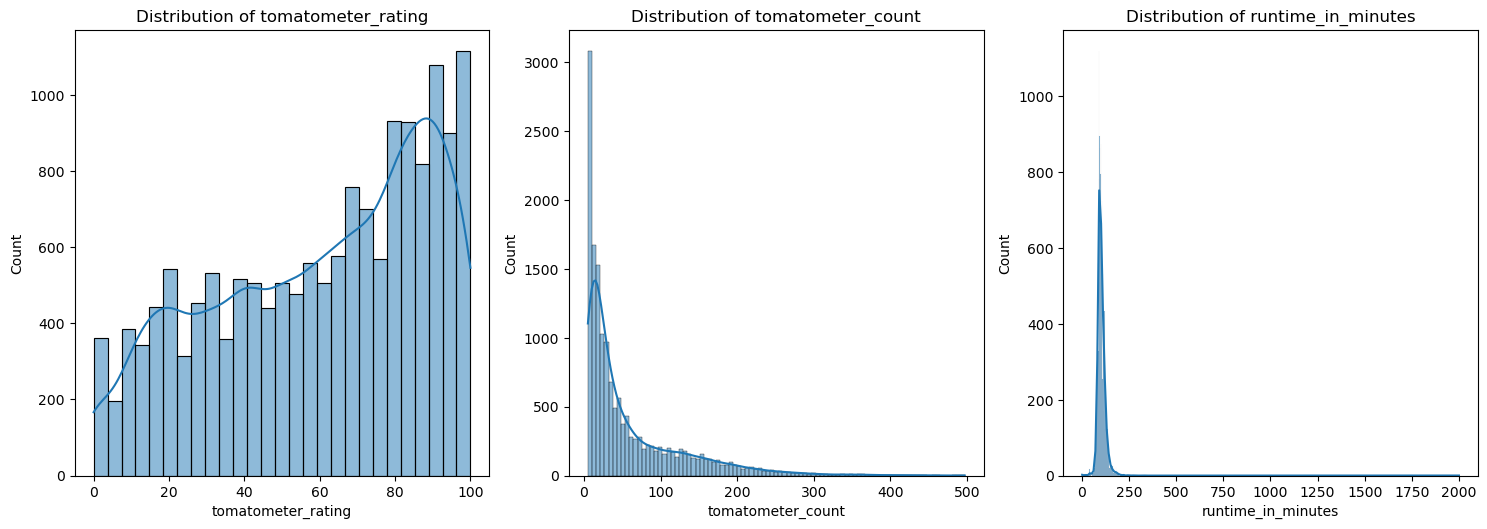

In [175]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(NUMERIC_COLS):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True) 
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Note: Ouliers will be removed during feature engineering

###  <font color="purple">2.5. Skewness of Numerical Features </font>

<font color="purple">**Skewness Analysis:**</font>
Skewness indicates the asymmetry in the data distribution. Highly skewed data may need transformation to improve model performance.


In [176]:
print("\nSkewness of Numerical Features:")
print(df[NUMERIC_COLS].skew())


Skewness of Numerical Features:
tomatometer_rating    -0.412557
tomatometer_count      1.948009
runtime_in_minutes    28.330966
dtype: float64


###  <font color="purple">2.6. Pairplot of Numerical Features </font>

<font color="purple">**Relationships between numerical variables:**</font>
Pairplots show how numerical variables relate to each other.


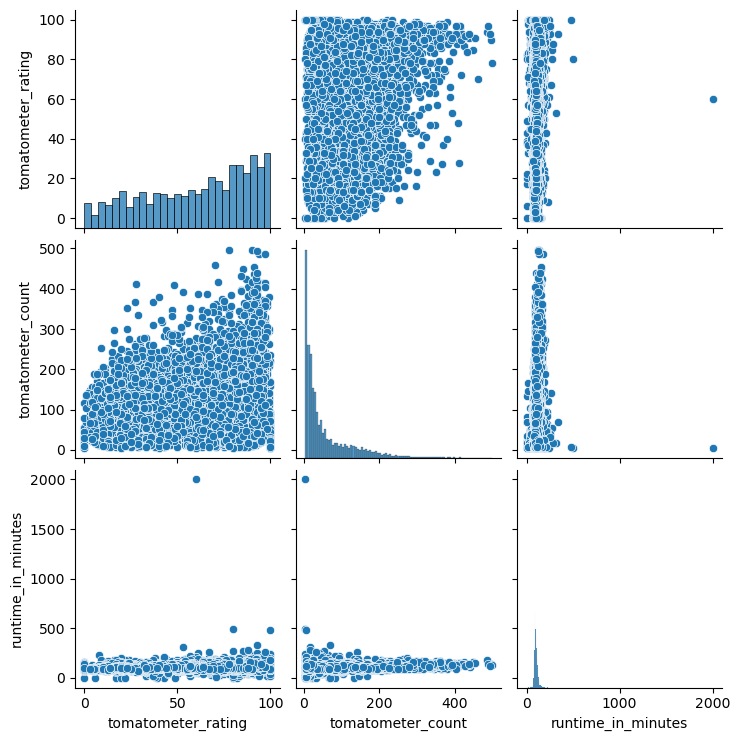

In [248]:
sns.pairplot(df[NUMERIC_COLS]) 
plt.show()

###  <font color="purple">2.7. Boxplots of Categorical Features vs Target </font>

<font color="purple">**Categorical Analysis:**</font>
We analyze the relationships between categorical features and the target variable ('audience_rating')

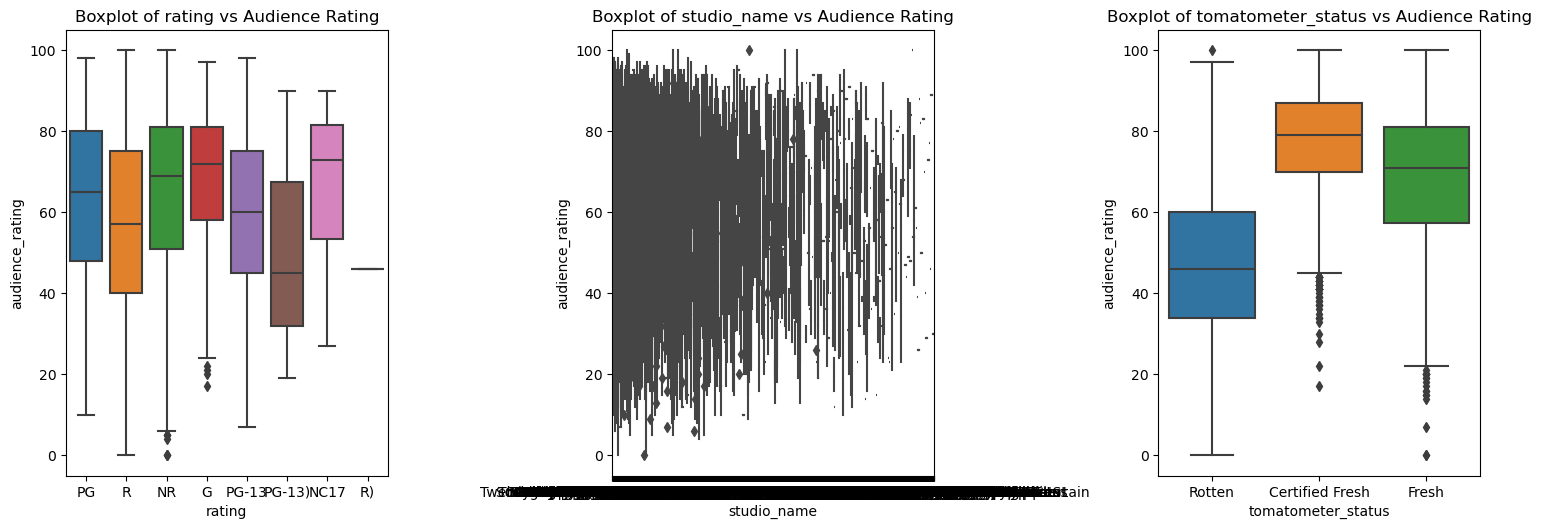

In [178]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(CATEGORICAL_COLS):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=col, y='audience_rating', data=df) 
    plt.title(f"Boxplot of {col} vs Audience Rating")
plt.tight_layout()
plt.show()

Note: Redundant informations from studio_name, need to be removed during feature engineering

###  <font color="purple">2.8. Correlation Matrix </font>

<font color="purple">**Correlation Matrix:**</font>
Displays the correlation between numerical features.


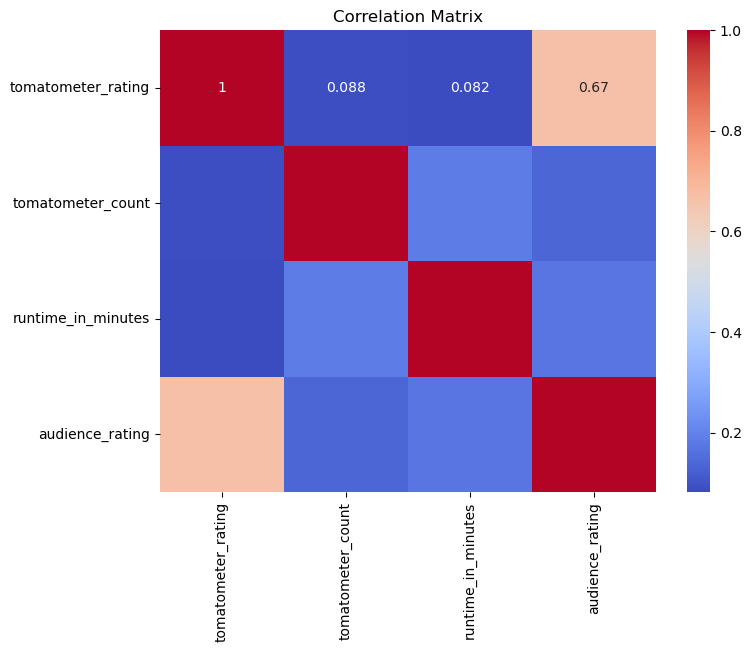

In [179]:
corr_matrix = df[NUMERIC_COLS + ['audience_rating']].corr() 
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

###  <font color="purple">2.9. Value Counts for Categorical Features </font>

<font color="purple">**Categorical Feature Distribution:**</font>
Examine the distribution of categorical variables to assess their diversity.


In [180]:
print("\nValue Counts for Categorical Features:")
for col in CATEGORICAL_COLS:
    print(f"\n{col}:\n{df[col].value_counts()}")  



Value Counts for Categorical Features:

rating:
rating
R         5995
NR        4311
PG-13     2837
PG        2007
G          634
NC17        35
PG-13)       3
R)           1
Name: count, dtype: int64

studio_name:
studio_name
Paramount Pictures                  493
Warner Bros. Pictures               487
Universal Pictures                  463
20th Century Fox                    414
IFC Films                           395
                                   ... 
Neue Road Movies                      1
First Run Pictures                    1
Evergreen Films                       1
Brookwell-McNamara Entertainment      1
Tango Entertainment                   1
Name: count, Length: 2698, dtype: int64

tomatometer_status:
tomatometer_status
Rotten             6937
Fresh              5957
Certified Fresh    2929
Name: count, dtype: int64


In [249]:
df['rating'] = df['rating'].str.replace(')', '')

Note: Removed ')' from the column Rating

##  <font color="purple">3. Feature Engineering </font>

<font color="purple">**Objective:**</font>
Feature engineering involves transforming raw data into a format that is more suitable for machine learning models. This involves handling dates, processing text, handling missing values, transforming skewed features, and feature selection.

### <font color="purple"> 3.1. Feature Engineering Functions </font>

<font color="purple">**Explanation:**</font>
The following functions implement feature engineering, including handling outliers, dates, text, numerical, categorical features and feature selection.


In [242]:
def remove_outliers(df, numerical_cols):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def handle_dates(df):
    for col in DATE_COLS:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
    df.drop(columns=DATE_COLS, inplace=True)
    return df

def handle_text(df):
    for col in TEXT_COLS:
        df[col] = df[col].fillna("")
    df['combined_text'] = df[TEXT_COLS].apply(lambda x: ' '.join(x), axis=1)
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')

    def preprocess_text(text):
        tokens = tokenizer.tokenize(text.lower())
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
        return ' '.join(tokens)

    df['combined_text'] = df['combined_text'].apply(preprocess_text)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])
    lda_model = LatentDirichletAllocation(n_components=N_TOPICS, random_state=RANDOM_STATE)
    lda_model.fit(tfidf_matrix)
    topic_labels = lda_model.transform(tfidf_matrix)
    topic_labels = np.argmax(topic_labels, axis=1)
    df['text_topic'] = topic_labels
    df.drop(columns=TEXT_COLS + ['combined_text'], inplace=True)
    return df

def handle_numerical(df):
    for col in NUMERIC_COLS:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    for col in ['tomatometer_count', 'runtime_in_minutes']:
        if df[col].skew() > 0.5:
            transformed_data, _ = stats.boxcox(df[col] + 1)
            df[f'{col}_transformed'] = transformed_data
            df.drop(columns=col, inplace=True)
        else:
            df[f'{col}_transformed'] = df[col]
            df.drop(columns=col, inplace=True)
    return df

def handle_categorical(df):
    for col in CATEGORICAL_COLS:
        df[col] = df[col].fillna("other")
    return df

def preprocess_and_encode(df):
    df = remove_outliers(df, NUMERIC_COLS)
    df = handle_dates(df)
    df = handle_text(df)
    df = handle_numerical(df)
    df = handle_categorical(df)
    return df

def feature_selection(df, target_col, cardinality_threshold=CARDINALITY_THRESHOLD):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols.remove(target_col)
    X = df[numerical_cols]
    y = df[target_col]
    
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(X)
    selected_numerical_features = X.columns[selector.get_support()]
    
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    selected_categorical_features = []
    for col in categorical_cols:
        if df[col].nunique() <= cardinality_threshold:
             selected_categorical_features.append(col)
    
    selected_features = [target_col] + selected_numerical_features.tolist() + selected_categorical_features
    df_selected = df[selected_features]

    numerical_cols_selected = df_selected.select_dtypes(include=np.number).columns.tolist()
    numerical_cols_selected.remove(target_col)

    X_selected = df_selected[numerical_cols_selected]
    corr_matrix = X_selected.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    
    df_selected.drop(columns=to_drop, inplace=True)
    return df_selected

##  <font color="purple">4. Model Building & Evaluation </font>

<font color="purple">**Objective:**</font>
This section involces prepare the data for machine learning, build a predictive model, evaluate its performance, and perform cross validation.

###  <font color="purple">4.1. Build Preprocessing Pipeline </font>

<font color="purple">**Preprocessing Steps:**</font>
The pipeline includes scaling of numerical features and one-hot encoding of categorical features.

In [243]:
def build_preprocessing_pipeline(numerical_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    return preprocessor

###  <font color="purple">4.2. Main Function </font>

<font color="purple">**Model Training and Evaluation:**</font>
This is the core function to process the data, train an XGBoost regression model, and validate it.


In [246]:

def main(df, target_col='audience_rating', top_n_features=TOP_N_FEATURES):
    df = preprocess_and_encode(df)
    df_selected = feature_selection(df, target_col)
    
    categorical_features = df_selected.select_dtypes(include='object').columns.tolist()
    for col in categorical_features:
        df_selected[col] = df_selected[col].astype(str)
    
    numerical_features = df_selected.select_dtypes(include=np.number).columns.tolist()
    numerical_features.remove(target_col)
    X = df_selected.drop(columns=target_col)
    y = df_selected[target_col]

    y_median = y.median()
    y = y.fillna(y_median) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    preprocessor = build_preprocessing_pipeline(numerical_features, categorical_features)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRoot Mean Squared Error on Test Set: {rmse}")

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    print(f"Cross-Validation RMSE scores: {(-cv_scores)}")
    print(f"Mean Cross-Validation RMSE: {-cv_scores.mean():.4f}")
    
    print("\nFeature Importances:")
    if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
         importances = pipeline.named_steps['model'].feature_importances_
         feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
         
         importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
         importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
         
         print(importance_df)
         
         top_features = importance_df['Feature'].head(top_n_features).tolist()
         print(f"\nTop {top_n_features} Features: {top_features}")

         original_feature_names = []
         for feature in top_features:
            if '__' in feature:
                prefix = feature.split('__')[0]
                if prefix == 'cat':
                    for col in categorical_features:
                        if f"cat__{col}" in feature:
                             original_feature_names.append(col)
                elif prefix == 'num':
                     for col in numerical_features:
                        if f"num__{col}" in feature:
                              original_feature_names.append(col)
            else:
                  original_feature_names.append(feature)
        
         original_feature_names = list(set(original_feature_names))
         
         X_train_top = X_train[original_feature_names]
         X_test_top = X_test[original_feature_names]
         
         
         preprocessor_top = build_preprocessing_pipeline(X_train_top.select_dtypes(include=np.number).columns.tolist(),
                                                        X_train_top.select_dtypes(include='object').columns.tolist())

         pipeline_top = Pipeline(steps=[('preprocessor', preprocessor_top),
                        ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE))])
         
         param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.8, 0.9],
            'model__colsample_bytree': [0.7, 0.8, 0.9]
           }

         grid_search = GridSearchCV(pipeline_top, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
         grid_search.fit(X_train_top, y_train)

         best_pipeline = grid_search.best_estimator_

         y_pred_top = best_pipeline.predict(X_test_top)
         rmse_top = np.sqrt(mean_squared_error(y_test, y_pred_top))
         print(f"\nRoot Mean Squared Error on Test Set (Top {top_n_features} Features with Tuning): {rmse_top}")
         
         cv_scores_top = cross_val_score(best_pipeline, X[original_feature_names], y, cv=cv, scoring='neg_root_mean_squared_error')
         print(f"Cross-Validation RMSE scores (Top {top_n_features} Features with Tuning): {(-cv_scores_top)}")
         print(f"Mean Cross-Validation RMSE (Top {top_n_features} Features with Tuning): {-cv_scores_top.mean():.4f}")
         
    else:
        print("Model does not support feature importance.")
    
    return pipeline

###  <font color="purple">4.3. Model Execution </font>

In [247]:
model_pipeline = main(df)


Root Mean Squared Error on Test Set: 14.709195796740413
Cross-Validation RMSE scores: [14.7091958  14.66885597 14.36996385 14.50451478 14.61598002]
Mean Cross-Validation RMSE: 14.5737

Feature Importances:
                                    Feature  Importance
0                   num__tomatometer_rating    0.329072
1                             cat__rating_R    0.104070
2                            cat__rating_NR    0.072838
3                            cat__rating_PG    0.063550
4                num__in_theaters_date_year    0.058408
5                         cat__rating_PG-13    0.058031
6       num__runtime_in_minutes_transformed    0.052111
7               num__on_streaming_date_year    0.049735
8                             cat__rating_G    0.048542
9        num__tomatometer_count_transformed    0.047391
10              num__in_theaters_date_month    0.033369
11             num__on_streaming_date_month    0.032758
12                         cat__rating_NC17    0.016182
13  cat__